In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from scipy.stats import skew
import warnings
warnings.filterwarnings('once')

In [93]:
metadata = pd.read_csv('Data/Metadata/102GL_meta_clim.csv')
metadata = metadata[~np.isnan(metadata['sba [cells g-1]'])]
metadata['lat_sp [DD]'] = np.abs(metadata['lat_sp [DD]'])
print(metadata.columns)
metadata.head()

Index(['Unnamed: 0', 'patch', 'Expedition', 'date [DD.MM.YYYY]',
       'time [HH:MM]', 'water_temp [°C]', 'ph [pH]', 'do [mg l-1]',
       'do_sat [saturation]', 'w_co2 [mATM]', 'conductivity [uS cm -1]',
       'turb [NTU]', 'gl_name', 'lat_sn [DD]', 'lon_sn [DD]', 'ele_sn [m]',
       'lat_sp [DD]', 'lon_sp [DD]', 'ele_sp [m]', 'sn_sp_dist [m]',
       'sn_sp_ele [m]', 'gl_sa [km2]', 'gl_cov [%]', 'gl_a [km2]', 'rgi_v6',
       'glims_id', 'chla [ug g-1]', 'eps [ugC g-1]', 'ag [nmol g-1 h-1]',
       'ap [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]',
       'nag [nmol g-1 h-1]', 'bp [ngC g-1 h-1]', 'sba [cells g-1]',
       'respiration [mg 02 g-1 h-1]', 'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]',
       'n5_no3 [ug l-1]', 'n6_no2 [ug l-1]', 'bio10', 'bio11', 'bio12',
       'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'bio1',
       'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'fcf',
       'fgd', 'scd', 'swe', 'pr', 'tas', 'tasmin', 'tas

,Unnamed: 0,patch,Expedition,date [DD.MM.YYYY],time [HH:MM],water_temp [°C],ph [pH],do [mg l-1],do_sat [saturation],w_co2 [mATM],...,bio8,bio9,fcf,fgd,scd,swe,pr,tas,tasmin,tasmax
0,0,GL1_UP_1,New Zealand,22.01.19,10:00,2.4,7.81,13.3,99.9,406.3,...,555.65,549.65,59,0,0,6553.5,585.7,559.45,555.75,562.85
1,1,GL1_UP_2,New Zealand,22.01.19,10:00,2.4,7.81,13.3,99.9,406.3,...,555.65,549.65,59,0,0,6553.5,585.7,559.45,555.75,562.85
2,2,GL1_UP_3,New Zealand,22.01.19,10:00,2.4,7.81,13.3,99.9,406.3,...,555.65,549.65,59,0,0,6553.5,585.7,559.45,555.75,562.85
3,3,GL1_DN_1,New Zealand,22.01.19,14:26,3.1,7.71,13.4,100.1,442.6,...,557.85,552.05,0,0,0,6553.5,524.1,561.55,557.95,564.75
4,4,GL1_DN_2,New Zealand,22.01.19,14:26,3.1,7.71,13.4,100.1,442.6,...,557.85,552.05,0,0,0,6553.5,524.1,561.55,557.95,564.75


In [94]:
data = pd.read_csv('data/16S/NOMIS_16S_merged_table_0122.csv', index_col = 0)

# Taxonomic filtering
tax_data = pd.read_csv('data/16S/NOMIS_16S_merged_taxonomy_0122.csv', header=0)
print(f'{tax_data.shape[0]} ASVs before taxonomic filtration')
tax_data = tax_data[tax_data.Order != ' o__Chloroplast']
tax_data = tax_data[~tax_data.Kingdom.isin(['d__Eukaryota','d__Archaea'])]
tax_data = tax_data[tax_data.Family != 'f__Mitochondria']
print(f'{tax_data.shape[0]} ASVs after taxonomic filtration')

data = data[data.index.isin(tax_data.Feature_ID)]

# subset sediment colums, remove the 16S_sed flag to match metadata
sed_cols = [col for col in data.columns if '16S_sed' in col]
data = data[sed_cols]
data.columns = [x.replace('_16S_sed','') for x in data.columns]
data = data[data.columns[data.columns.isin(metadata.patch)]]
metadata = metadata[metadata.patch.isin(data.columns)]

# Gather the cell counts, normalise the columns
cols_cell_count = [metadata.loc[metadata.patch == patch, 'sba [cells g-1]'].values[0] for patch in data.columns]
data = data / data.sum()
asvs_prevalence = (data > 0).mean(axis=1)

abundances = data[asvs_prevalence > 0.1].sum(axis=0)

data = data.multiply(cols_cell_count)
data = data[asvs_prevalence > 0.1]

tax_data = tax_data[tax_data.Feature_ID.isin(data.index)]
data.to_csv('data/16S/NOMIS_16S_table_0122_filtered.csv')
tax_data.to_csv('data/16S/NOMIS_16S_taxonomy_0122_filtered.csv')

print(f'Starting number of ASVs: {asvs_prevalence.shape[0]}')
print(f'Ending number of ASVs: {data.shape[0]}')
print(f'Taxonomic filtration test: {tax_data.shape[0]}')
print(metadata.shape)

312422 ASVs before taxonomic filtration
308092 ASVs after taxonomic filtration
Starting number of ASVs: 308092
Ending number of ASVs: 3346
Taxonomic filtration test: 3346
(512, 67)


0.7174857803595938


<AxesSubplot:>

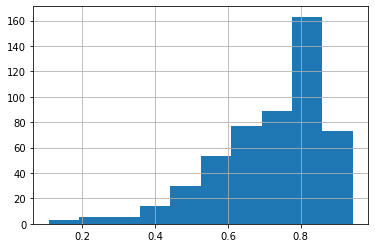

In [95]:
print(abundances.mean())
abundances.hist()

# 1 Predictive power analysis

In [91]:
data = data.sort_index(axis=1)
metadata = metadata.sort_values(by = 'patch')
print(metadata.patch == data.columns)

le = preprocessing.LabelEncoder()
le.fit(metadata['Expedition'])
metadata['Expedition'] = le.transform(metadata['Expedition'])

features = ['water_temp [°C]', 'ph [pH]', 'lat_sp [DD]',
       'do_sat [saturation]', 'conductivity [uS cm -1]',
       'turb [NTU]', 'ele_sp [m]', 'gl_sa [km2]', 'gl_cov [%]',
       'chla [ug g-1]', 'eps [ugC g-1]', 'ag [nmol g-1 h-1]',
       'ap [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]',
       'nag [nmol g-1 h-1]', 'bp [ngC g-1 h-1]',
       'respiration [mg 02 g-1 h-1]', 'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]',
       'n5_no3 [ug l-1]', 'n6_no2 [ug l-1]', 'bio10', 'bio11', 'bio12',
       'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'bio1',
       'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'fcf',
       'fgd', 'scd', 'swe', 'pr', 'tas', 'tasmin', 'tasmax']

X = metadata[features]

print(metadata.shape)
print(X.shape)
print(X.columns)

sdm_out = pd.DataFrame(columns = ['Species', 'r2'] + X.columns.tolist())
count = 0

for ASV in data.index:
    count += 1
    print(count, end='\r')
    
    y = np.log(data.loc[ASV].values.ravel() + 1)
    preval = np.mean(y > 0)
    
    to_remove = np.isnan(y)
    X = X[~to_remove]
    y = y[~to_remove]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    clf = HistGradientBoostingRegressor(random_state=0, 
                                        scoring = 'r2')
    clf.fit(X_train, y_train)
    imp_res = permutation_importance(clf, X_test, y_test, n_repeats=20, random_state=0, n_jobs=10)
    r2 = r2_score(y_test, clf.predict(X_test))
        
    sdm_out.loc[ASV] = [ASV, r2] + imp_res['importances_mean'].tolist()

591    True
592    True
593    True
588    True
589    True
       ... 
46     True
47     True
42     True
43     True
44     True
Length: 512, dtype: bool
(512, 67)
(512, 49)
Index(['water_temp [°C]', 'ph [pH]', 'lat_sp [DD]', 'do_sat [saturation]',
       'conductivity [uS cm -1]', 'turb [NTU]', 'ele_sp [m]', 'gl_sa [km2]',
       'gl_cov [%]', 'chla [ug g-1]', 'eps [ugC g-1]', 'ag [nmol g-1 h-1]',
       'ap [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]',
       'nag [nmol g-1 h-1]', 'bp [ngC g-1 h-1]', 'respiration [mg 02 g-1 h-1]',
       'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]',
       'n6_no2 [ug l-1]', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15',
       'bio16', 'bio17', 'bio18', 'bio19', 'bio1', 'bio2', 'bio3', 'bio4',
       'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'fcf', 'fgd', 'scd', 'swe',
       'pr', 'tas', 'tasmin', 'tasmax'],
      dtype='object')


KeyboardInterrupt: 

In [49]:
imp_mat = sdm_out[features]
imp_mat.index = sdm_out.Species
print(imp_mat.shape)
imp_mat.head()

(3346, 49)


,water_temp [°C],ph [pH],lat_sp [DD],do_sat [saturation],conductivity [uS cm -1],turb [NTU],ele_sp [m],gl_sa [km2],gl_cov [%],chla [ug g-1],...,bio8,bio9,fcf,fgd,scd,swe,pr,tas,tasmin,tasmax
Species,,,,,,,,,,,,,,,,,,,,,
2e943a3f37ba3e500d42f24238ff6667,0.062308,0.019013,0.042638,0.009266,0.000588,0.118762,0.000543,0.025230,0.025739,0.011081,...,0.010828,0.191304,-0.000590,0.006654,0.001460,0.000342,-0.000768,0.016821,0.002685,0.004437
93f52e347e69b67e42f5979bb8735255,0.024987,0.001745,0.003126,0.002478,0.000242,0.003925,0.015637,-0.001302,0.002108,-0.000015,...,0.003592,-0.000022,0.111922,0.000456,0.001558,-0.006310,-0.002871,0.000771,-0.000159,0.000525
eb8353802171a7c60f55e1b48aa12158,0.003697,0.003591,0.055180,0.001100,0.001202,0.032167,-0.000004,0.001081,0.007506,-0.001396,...,0.002219,-0.000452,0.012853,-0.000242,0.000481,0.001660,0.001294,-0.000627,0.004247,0.001900
f19127b849d2529b57589e7ae1f1a388,0.042176,0.003715,0.000880,0.003435,0.174640,0.059263,0.005973,-0.000905,0.003021,0.004855,...,0.002322,0.000990,0.005601,0.000515,0.000098,0.006929,0.000619,-0.000178,0.000423,0.001761
227b2dc5798a05133e1dc46f13ac1033,0.045154,0.093770,0.084947,0.001534,0.025701,0.102957,0.003313,0.018139,0.005268,0.002761,...,0.026946,-0.000391,0.019227,0.000162,0.004701,0.003286,-0.004519,0.009494,0.008177,0.007280


In [59]:
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []
k_vals = np.arange(2,20)

for k in k_vals:
    print(k, end='\r')
    kmeans = KMeans(n_clusters=k, random_state=0).fit(imp_mat)
    silhouette.append(silhouette_score(imp_mat, kmeans.labels_, metric = 'euclidean'))
    inertia.append(kmeans.inertia_)

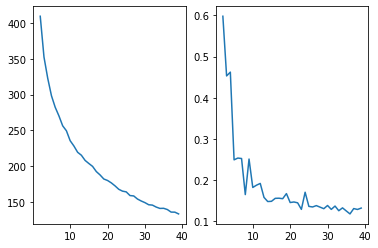

In [60]:
fig, axs = plt.subplots(1,2)
axs[0].plot(k_vals, inertia)
axs[1].plot(k_vals, silhouette)

In [81]:
final_kmeans = KMeans(n_clusters=24, random_state=0).fit(imp_mat)
print(imp_mat.shape)
print(list(set(final_kmeans.labels_)))
tax_data['Cluster'] = final_kmeans.labels_
tax_data.to_csv('data/16S/NOMIS_16S_taxonomy_0122_filtered.csv')

(3346, 49)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [82]:
for cluster in list(set(final_kmeans.labels_)):
    print(f'Cluster number: {cluster}', end='\r')
    clust_asvs = imp_mat.index[final_kmeans.labels_ == cluster]
    
    sub_df = pd.DataFrame()
    for asv in clust_asvs:
        for feature in features:
            sub_df = pd.concat([sub_df, pd.DataFrame({'ASV':asv,'Feature':feature,'Importance':imp_mat.loc[imp_mat.index == asv, feature].values[0]}, index=[sub_df.shape[0]])])
    print(f'  - ASV number: {len(set(sub_df.ASV.tolist()))}')
    
    avgs = sub_df.groupby(["Feature"])['Importance'].median().reset_index().sort_values('Importance')
    plt.figure(figsize=(20,15))
    plt.axvline(x=0, color='black', linewidth=0.75)
    sns.boxplot(data=sub_df, x='Importance', y='Feature', palette='crest', 
                order=avgs['Feature'], showfliers = False)
    plt.savefig(f'1_Data_exploration/1_feature_importance_permutations_cluster{cluster}.pdf')
    plt.close()


  - ASV number: 87
  - ASV number: 59
  - ASV number: 7
  - ASV number: 55
  - ASV number: 235
  - ASV number: 174
  - ASV number: 62
  - ASV number: 267
  - ASV number: 246
  - ASV number: 1498
  - ASV number: 20
  - ASV number: 19
  - ASV number: 19
  - ASV number: 72
  - ASV number: 102
  - ASV number: 15
  - ASV number: 31
  - ASV number: 17
  - ASV number: 73
  - ASV number: 73
  - ASV number: 115
  - ASV number: 28
  - ASV number: 82
  - ASV number: 20


In [ ]:
- Glaciological/Geographical: Expedition, Glacier coverage, pH, Water Temp
- Climatic: tasmin, pr, bio8, bio9, bio5
- BioGeoChemical: n5, n4, n3, Turb, Conductivity 
- Biological: Chla, bp, bg, lap, respiration

# 2 Correlation analysis

<AxesSubplot:>

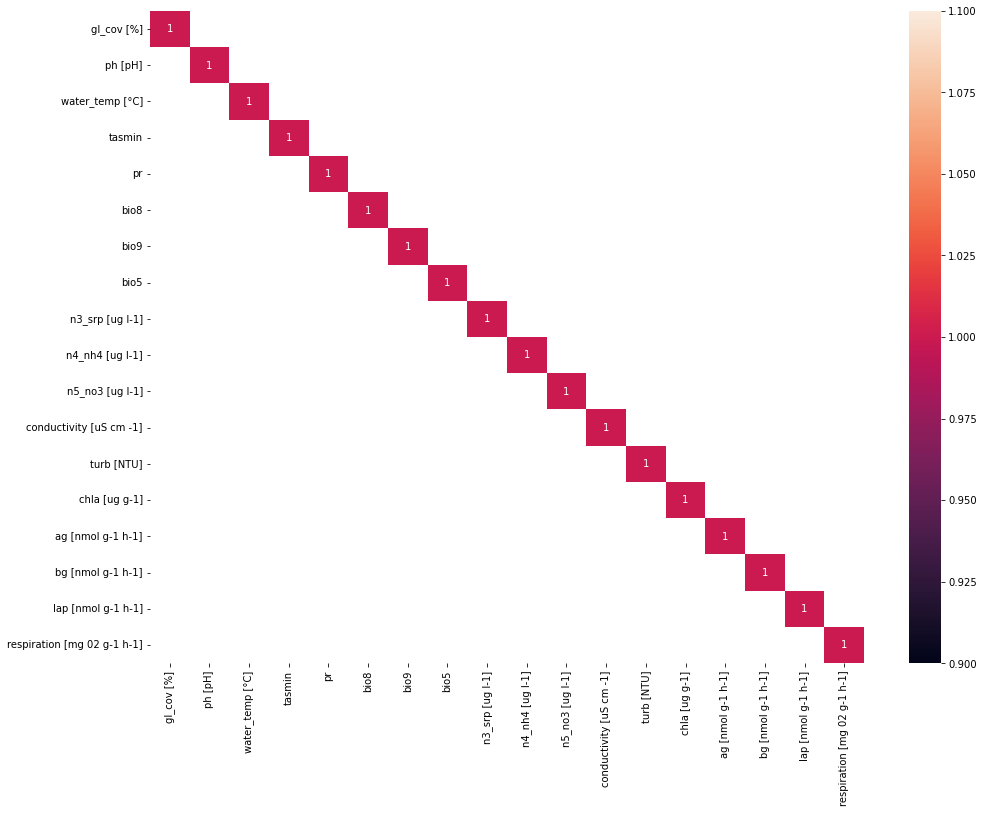

In [198]:
corrs = metadata[['gl_cov [%]', 'ph [pH]', 'water_temp [°C]',
                  'tasmin', 'pr', 'bio8', 'bio9', 'bio5',
                  'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 
                  'conductivity [uS cm -1]', 'turb [NTU]', 
                  'chla [ug g-1]','ag [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]',
                  'respiration [mg 02 g-1 h-1]']].corr()
corrs[(corrs < 0.7) & (corrs >= 0)] = np.nan
corrs[(corrs > -0.7) & (corrs <= 0)] = np.nan 
(fig, ax) = plt.subplots(figsize=(16, 12))
sns.heatmap(corrs, annot=True)

# 3 PCA analysis

(512, 18)


,Unnamed: 0,patch,Expedition,date [DD.MM.YYYY],time [HH:MM],water_temp [°C],ph [pH],do [mg l-1],do_sat [saturation],w_co2 [mATM],...,scd,swe,pr,tas,tasmin,tasmax,PC1,PC2,PC3,PC4
591,591,GL100_DN_1,Alps,29.09.20,15:00,2.2,7.82,10.5,98.7,227.4,...,291,605.1,185.0,552.75,547.15,557.25,0.632835,-2.304531,0.109930,0.848395
592,592,GL100_DN_2,Alps,29.09.20,15:00,2.2,7.82,10.5,98.7,227.4,...,291,605.1,185.0,552.75,547.15,557.25,0.688580,-2.249505,0.155126,0.885737
593,593,GL100_DN_3,Alps,29.09.20,15:00,2.2,7.82,10.5,98.7,227.4,...,291,605.1,185.0,552.75,547.15,557.25,0.609242,-2.290512,0.164889,0.862128
588,588,GL100_UP_1,Alps,29.09.20,12:17,1.2,7.80,10.7,99.1,238.5,...,291,605.1,185.0,552.75,547.15,557.25,0.459440,-2.382234,0.087484,1.215130
589,589,GL100_UP_2,Alps,29.09.20,12:17,1.2,7.80,10.7,99.1,238.5,...,291,605.1,185.0,552.75,547.15,557.25,0.930381,-1.937439,0.303616,1.429827


[0.17932726 0.15763307 0.12980166 0.07638469]


/Users/mabourqu/opt/anaconda3/envs/SDMs/lib/python3.10/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
/Users/mabourqu/opt/anaconda3/envs/SDMs/lib/python3.10/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


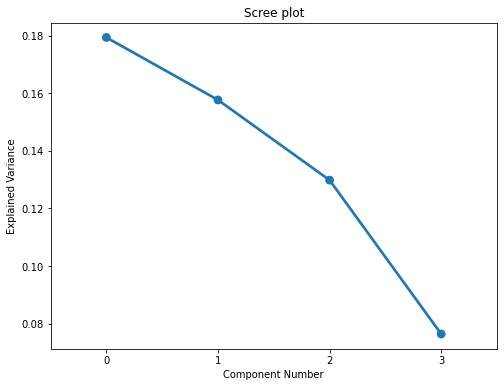

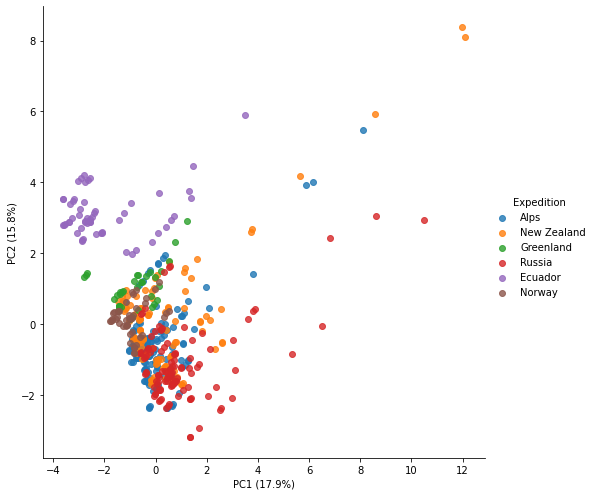

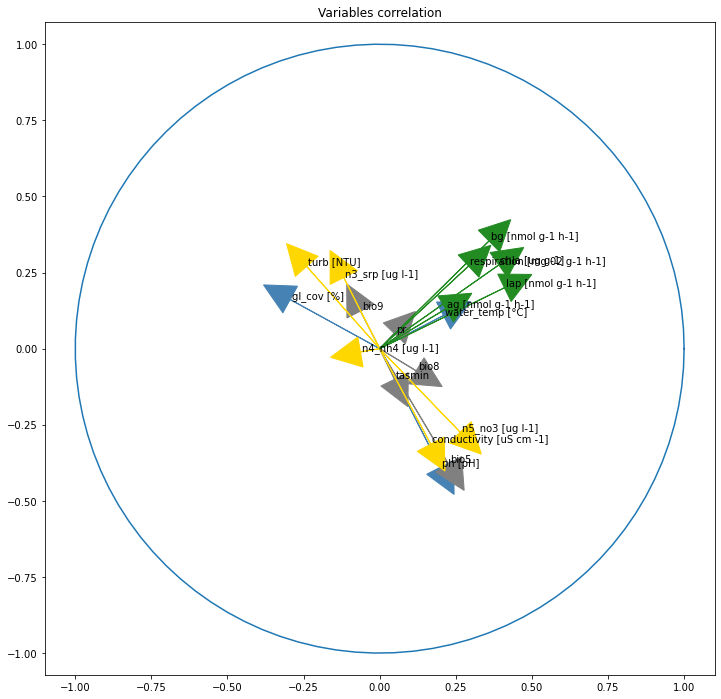

In [201]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

n_components = 4
 
# Do the PCA.
pca = PCA(n_components=n_components)
features = ['gl_cov [%]', 'ph [pH]', 'water_temp [°C]',
                  'tasmin', 'pr', 'bio8', 'bio9', 'bio5',
                  'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 
                  'conductivity [uS cm -1]', 'turb [NTU]', 
                  'chla [ug g-1]','ag [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]',
                  'respiration [mg 02 g-1 h-1]']
pca_data = metadata[features]


pca_data = pca_data.fillna(pca_data.mean()).values
norm_scaler = preprocessing.StandardScaler()
pca_data = norm_scaler.fit_transform(pca_data)
pca_data = pd.DataFrame(pca_data, columns=features)

print(pca_data.shape)
reduced = pca.fit_transform(pca_data)

# Append the principle components for each entry to the dataframe
for i in range(0, n_components):
    metadata['PC' + str(i + 1)] = reduced[:, i]

display(metadata.head())

# Do a scree plot
print(pca.explained_variance_ratio_)
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.savefig('1_Data_exploration/1_PCA_eigenvals.pdf')

# Show the points in terms of the first two PCs
g = sns.lmplot(x='PC1',
               y='PC2',
               data=metadata,
               hue='Expedition',
               fit_reg=False,
               scatter=True,
               height=7)
plt.xlabel('PC1 (17.9%)')
plt.ylabel('PC2 (15.8%)')

plt.savefig('1_Data_exploration/1_PCA_components.pdf')



# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(12, 12))
for i in range(0, pca.components_.shape[1]):
    feature = pca_data.columns.values[i]
    if feature in ['gl_cov [%]', 'ph [pH]', 'water_temp [°C]']:
        color = 'steelblue'
    elif feature in ['n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 
                  'conductivity [uS cm -1]', 'turb [NTU]']:
        color = 'gold'
    elif feature in [ 'fcf', 'fgd', 'scd', 'swe', 'pr', 'tas', 'tasmin', 'tasmax',
                    'bio10', 'bio11', 'bio12',
       'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'bio1',
       'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9']:
        color = 'grey'
    else:
        color = 'forestgreen'
    
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1,
            color=color)

    plt.text(pca.components_[0, i] + 0.005,
             pca.components_[1, i] + 0.005,
             pca_data.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variables correlation')
plt.savefig('1_Data_exploration/1_PCA_vars.pdf')


# 2 Data description

<AxesSubplot:>

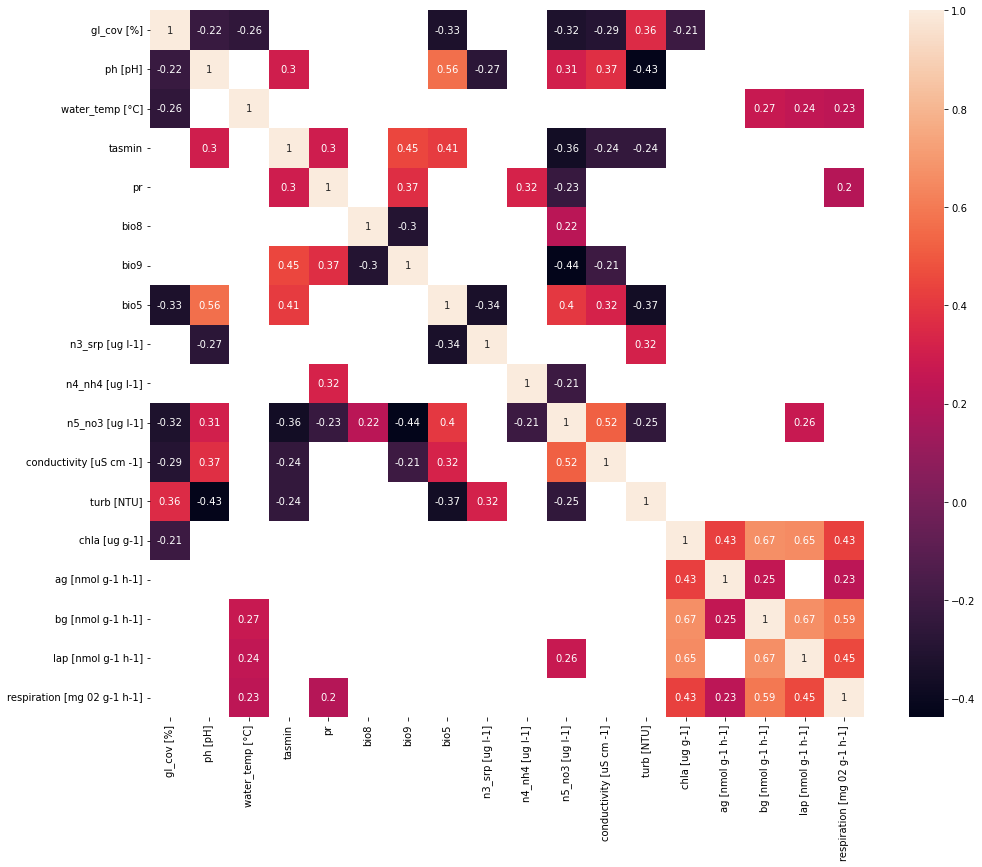

In [202]:
corrs = metadata[['gl_cov [%]', 'ph [pH]', 'water_temp [°C]',
                  'tasmin', 'pr', 'bio8', 'bio9', 'bio5',
                  'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 
                  'conductivity [uS cm -1]', 'turb [NTU]', 
                  'chla [ug g-1]','ag [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]',
                  'respiration [mg 02 g-1 h-1]']].corr()
corrs[(corrs < 0.2) & (corrs >= 0)] = np.nan
corrs[(corrs > -0.2) & (corrs <= 0)] = np.nan 
(fig, ax) = plt.subplots(figsize=(16, 13))
sns.heatmap(corrs, annot=True)

# 3 Predicting variables with other variables

In [205]:
glacier_params = ['gl_cov [%]', 'ph [pH]', 'water_temp [°C]']
climatic_params = ['tasmin', 'pr', 'bio8', 'bio9', 'bio5']
biogeochem_params = ['n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 
                     'conductivity [uS cm -1]', 'turb [NTU]']
microbial_params = ['chla [ug g-1]','ag [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]',
                    'respiration [mg 02 g-1 h-1]']

In [255]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
import matplotlib.pyplot as plt

print('BIOGEOCHEMICAL PARAMETERS:')
for param in biogeochem_params:
    print('-------------------')
    print(param)
    X = metadata[glacier_params + climatic_params]
    y = metadata[param]
    
    to_remove = np.isnan(y)
    X = X[~to_remove]
    y = y[~to_remove]
    
    to_remove = np.isnan(X).any(axis=1)
    X = X[~to_remove]
    y = y[~to_remove]
    
    kf = model_selection.RepeatedKFold(n_splits=5, n_repeats=20)
    model = linear_model.HuberRegressor(max_iter=1000)
    #reg = HistGradientBoostingRegressor(loss='squared_error',
    #                                    learning_rate=0.05,
    #                                    max_iter=1000,
    #                                    l2_regularization=0.01)
    
    cv_res = model_selection.cross_validate(model, X, y, cv=kf, scoring='r2', return_estimator=True)
    
    r2_score = cv_res['test_score'].mean()
    print(f'  - {r2_score}')

print('\n\nMICROBIAL PARAMETERS:')
for param in microbial_params:
    print('-------------------')
    print(param)
    X = metadata[glacier_params + climatic_params + biogeochem_params]
    y = metadata[param]
    
    to_remove = np.isnan(y)
    X = X[~to_remove]
    y = y[~to_remove]
    
    to_remove = np.isnan(X).any(axis=1)
    X = X[~to_remove]
    y = y[~to_remove]
    
    kf = model_selection.RepeatedKFold(n_splits=5, n_repeats=20)
    model = make_pipeline(SplineTransformer(n_knots=4, degree=3), linear_model.BayesianRidge(alpha_1=1))
    cv_res = model_selection.cross_validate(model, X, y, cv=kf, scoring='r2', return_estimator=True)
    
    r2_score = cv_res['test_score'].mean()
    print(f'  - {r2_score}')

BIOGEOCHEMICAL PARAMETERS:
-------------------
n3_srp [ug l-1]
  - 0.034915509601622714
-------------------
n4_nh4 [ug l-1]
  - 0.07219207142745528
-------------------
n5_no3 [ug l-1]
  - 0.57005160047959
-------------------
conductivity [uS cm -1]
  - 0.32262869604750144
-------------------
turb [NTU]
  - 0.124813082934446


MICROBIAL PARAMETERS:
-------------------
chla [ug g-1]
  - 0.1528534586459503
-------------------
ag [nmol g-1 h-1]
  - -0.2568885938994786
-------------------
bg [nmol g-1 h-1]
  - 0.1287741125609918
-------------------
lap [nmol g-1 h-1]
  - 0.11505618711657467
-------------------
respiration [mg 02 g-1 h-1]
  - 0.004196549652438854


In [210]:
features = glacier_params + climatic_params

for feat in ['n5_no3 [ug l-1]', 'conductivity [uS cm -1]', 'n3_srp [ug l-1]', 'turb [NTU]', 'n4_nh4 [ug l-1]',
             'lap [nmol g-1 h-1]', 'chla [ug g-1]', 'respiration [mg 02 g-1 h-1]', 'bg [nmol g-1 h-1]', 
             'ag [nmol g-1 h-1]']:
    print('-------------------')
    print(feat)
    X = metadata[features]
    y = metadata[feat]
    
    to_remove = np.isnan(y)
    X = X[~to_remove]
    y = y[~to_remove]
    
    kf = model_selection.RepeatedKFold(n_splits=5, n_repeats=10)
    reg = HistGradientBoostingRegressor(loss='squared_error',
                                        learning_rate=0.05,
                                        max_iter=200,
                                        l2_regularization=0.01)
    cv_res = model_selection.cross_validate(reg, X, y, cv=kf, scoring='r2', return_estimator=True)
    
    r2_score = cv_res['test_score'].mean()
    print(f'  - {r2_score}')
    
    features.append(feat)

-------------------
n5_no3 [ug l-1]
  - 0.9549008266161237
-------------------
conductivity [uS cm -1]
  - 0.9615881712816662
-------------------
n3_srp [ug l-1]
  - 0.9206229880599001
-------------------
turb [NTU]
  - 0.8897162676177376
-------------------
n4_nh4 [ug l-1]
  - 0.9127059177880429
-------------------
lap [nmol g-1 h-1]
  - 0.6309627645225481
-------------------
chla [ug g-1]
  - 0.5408565905881407
-------------------
respiration [mg 02 g-1 h-1]
  - 0.5161677626873294
-------------------
bg [nmol g-1 h-1]
  - 0.5472068918937469
-------------------
ag [nmol g-1 h-1]
  - -0.9726923570240289
